In [1]:
using DataFrames
using Underscores

In [2]:
using Pkg
using Chain

In [24]:
using Plots
gr()

Plots.GRBackend()

In [25]:
abstract type Team end
struct Aligned <: Team end
struct Unaligned <: Team end

In [26]:
aligned = Aligned()
unaligned = Unaligned()

Unaligned()

In [27]:
world1 = 1
world2 = 2

2

In [28]:
worlds = [world1, world2]

2-element Array{Int64,1}:
 1
 2

In [29]:
teams = [aligned, unaligned]

2-element Array{Team,1}:
 Aligned()
 Unaligned()

In [30]:
function make_rows(teams, worlds, aligned_measure, starting_resources)
    rows = []
    for i in eachindex(teams), j in eachindex(worlds)
        team = teams[i]
        world = worlds[j]
        if team == aligned
            measure = aligned_measure
        else
            measure = 1.0
        end
        if i == j
            resource = starting_resources
        else
            resource = 0.0
        end
        
        row = (team = team, world = world, measure = measure, resource = resource)
        push!(rows, row)
    end
    return rows
end
                


make_rows (generic function with 1 method)

In [42]:
function get_utility(data; resource_col = "resource")
    return data.measure .* log10.(data[!, resource_col] .+ 1.0)
end

get_utility (generic function with 1 method)

In [43]:
function equal_split_bargaining_strategy(data)
    # A simple bargaining strategy where we assume a successful negotiation
    # results in splitting resources evenly across each world. 
    resources_df = @chain data begin
    groupby(_, :world)
    combine(_, :resource => sum)
    end
    
    num_teams = length(unique(data.team))
    resources_df.resource_sum /= 2
    rename!(resources_df, ("resource_sum" => "bargain_resource")) 
    return innerjoin(data, resources_df, on=:world)
end
    
    
    
    
   

equal_split_bargaining_strategy (generic function with 1 method)

In [44]:
function standard_failure(data)
    return get_utility(data, resource_col="resource")
end

standard_failure (generic function with 1 method)

In [48]:
function expected_utilities(data, utility_fn, bargaining_strategy, bargain_failure_utility, p_bargaining_success)
    # Get expected utility grouped by team, based on the utility, bargaining strategy, and probability
    # that bargaining succeeds
    data_with_bargain_resources = bargaining_strategy(data)
    bargain_success_utility = utility_fn(data_with_bargain_resources, resource_col="bargain_resource")
    bargain_fail_utility = bargain_failure_utility(data_with_bargain_resources)
    data_with_bargain_resources[!, "expected_utility"] = p_bargaining_success .* bargain_success_utility + (1 - p_bargaining_success) .* bargain_fail_utility
    return data_with_bargain_resources
end
    
    

expected_utilities (generic function with 1 method)

In [49]:
function aligned_utility(teams, worlds, get_utility, bargaining_strategy, bargain_failure_utility, p_bargaining_success, aligned_measure, initial_resource)
    df = make_rows(teams, worlds, aligned_measure, initial_resource) |> DataFrame
    eu = expected_utilities(df, get_utility, bargaining_strategy, bargain_failure_utility, p_bargaining_success)
    return @_ eu |> filter(_.team == aligned, __) |> sum(__.expected_utility)
end

aligned_utility (generic function with 1 method)

In [50]:
aligned_utility(teams, worlds, get_utility, equal_split_bargaining_strategy, standard_failure, .1, .1, 10e22)

2.523979400086721

In [51]:
measures = [10.0^n for n in -2:2]

5-element Array{Float64,1}:
   0.01
   0.1
   1.0
  10.0
 100.0

In [52]:
probabilities = LinRange(1e-3, 1 - 1e-3, 5)

5-element LinRange{Float64}:
 0.001,0.2505,0.5,0.7495,0.999

In [53]:
function utility_from_measure_and_probability((probability, measure))
    return aligned_utility(teams, worlds, get_utility, equal_split_bargaining_strategy, standard_failure, probability, measure, 1e22)
end

utility_from_measure_and_probability (generic function with 1 method)

In [54]:
mat = Base.product(probabilities, measures) |> collect

5×5 Array{Tuple{Float64,Float64},2}:
 (0.001, 0.01)   (0.001, 0.1)   …  (0.001, 10.0)   (0.001, 100.0)
 (0.2505, 0.01)  (0.2505, 0.1)     (0.2505, 10.0)  (0.2505, 100.0)
 (0.5, 0.01)     (0.5, 0.1)        (0.5, 10.0)     (0.5, 100.0)
 (0.7495, 0.01)  (0.7495, 0.1)     (0.7495, 10.0)  (0.7495, 100.0)
 (0.999, 0.01)   (0.999, 0.1)      (0.999, 10.0)   (0.999, 100.0)

In [55]:
utilities_grid = map(utility_from_measure_and_probability, mat)

5×5 Array{Float64,2}:
 0.220214  2.20214  22.0214  220.214  2202.14
 0.273602  2.73602  27.3602  273.602  2736.02
 0.32699   3.2699   32.699   326.99   3269.9
 0.380378  3.80378  38.0378  380.378  3803.78
 0.433765  4.33765  43.3765  433.765  4337.65

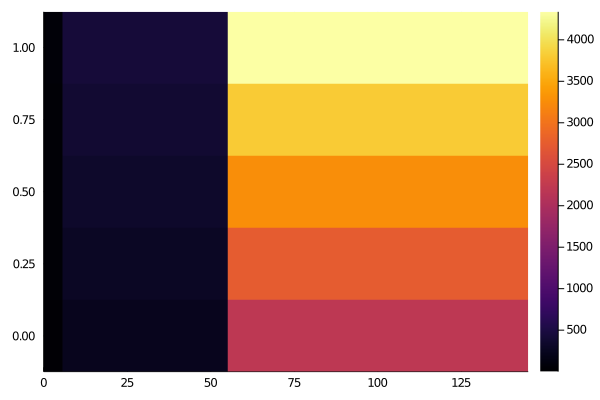

In [56]:
h = heatmap(measures, probabilities, utilities_grid)